In [62]:
import numpy as np
import pandas as pd
import requests
import subprocess
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers

import keras


from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import scipy.stats as stats
import matplotlib.pyplot as plt

# For Reproducibility
np.random.seed(42)
tf.random.set_seed(42)



data_link = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/015/039/original/dataset.csv.zip?1663710760"



def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

download_url(url=data_link, save_path='data/dataset.zip')

# importing required modules
from zipfile import ZipFile

# specifying the zip file name
file_name = "my_python_files.zip"

# opening the zip file in READ mode
with ZipFile('data/dataset.zip', 'r') as zip:
	# printing all the contents of the zip file
	zip.printdir()

	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')


# moving the data to data folder
subprocess.run(['mv', 'dataset.csv', 'data'])

# removing the dataset.zip file from the data folder
subprocess.run(['rm', '-r', 'data/dataset.zip'])

File Name                                             Modified             Size
dataset.csv                                    2022-04-12 14:09:50     23759573
Extracting all the files now...
Done!


CompletedProcess(args=['rm', '-r', 'data/dataset.zip'], returncode=0)

## What Porter is all about?

Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

Porter works with a wide range of restaurants for delivering their items directly to the people.

Porter has a number of delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers on the basis of what they are ordering, from where and also the delivery partners.

We intend to do the delivery time estimation, based on all those features

## Dictionary

- market_id : integer id for the market where the restaurant lies
- created_at : the timestamp at which the order was placed
- actual_delivery_time : the timestamp when the order was delivered
- store_primary_category : category for the restaurant
- order_protocol : integer code value for order protocol(how the order was placed ie: through porter, call to restaurant, pre booked, third part etc)
- total_items subtotal : final price of the order
- num_distinct_items : the number of distinct items in the order
- min_item_price : price of the cheapest item in the order
- max_item_price : price of the costliest item in order
- total_onshift_partners : number of delivery partners on duty at the time order was placed
- total_busy_partners : number of delivery partners attending to other tasks
- total_outstanding_orders : total number of orders to be fulfilled at the moment

In [2]:

df = pd.read_csv("data/dataset.csv", date_format=['created_at', 'actual_delivery_time'], parse_dates=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

df['Hour_of_day'] = df['created_at'].dt.hour

df['day_of_week'] = df['created_at'].dt.day_of_week

df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,22,4
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,21,1
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,20,3
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,21,1
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,2,6


In [3]:
alpha = 0.05
def null_checker(p, alpha =0.05):
    
    # Hypothesis significance checker code
    if p<alpha:
        print("Reject the null hypothesis")
    else:
        print("Failed to Reject the null hypothesis")

def qq_plot(x):
    # Code to draw qqplots for univariate analysis
    m = x.name
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = x.to_list()
    res = stats.probplot(x, dist=stats.norm, plot=ax)
    
    ax.set_title(f"Probplot for normal dist for {m}")

In [4]:
df.info()
# market_id, actual_delivery_time, store_primary_category, order_protocol, total_onshift_partners, total_busy_partners, total_outstanding_orders have missing values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 196441 non-null  float64       
 1   created_at                197428 non-null  datetime64[ns]
 2   actual_delivery_time      197421 non-null  datetime64[ns]
 3   store_id                  197428 non-null  object        
 4   store_primary_category    192668 non-null  object        
 5   order_protocol            196433 non-null  float64       
 6   total_items               197428 non-null  int64         
 7   subtotal                  197428 non-null  int64         
 8   num_distinct_items        197428 non-null  int64         
 9   min_item_price            197428 non-null  int64         
 10  max_item_price            197428 non-null  int64         
 11  total_onshift_partners    181166 non-null  float64       
 12  to

In [5]:
# Percentage of missing values
round(df.isna().sum()*100/df.shape[0], 2)

market_id                   0.50
created_at                  0.00
actual_delivery_time        0.00
store_id                    0.00
store_primary_category      2.41
order_protocol              0.50
total_items                 0.00
subtotal                    0.00
num_distinct_items          0.00
min_item_price              0.00
max_item_price              0.00
total_onshift_partners      8.24
total_busy_partners         8.24
total_outstanding_orders    8.24
Hour_of_day                 0.00
day_of_week                 0.00
dtype: float64

In [6]:
df.dtypes

market_id                          float64
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_id                            object
store_primary_category              object
order_protocol                     float64
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64
total_onshift_partners             float64
total_busy_partners                float64
total_outstanding_orders           float64
Hour_of_day                          int32
day_of_week                          int32
dtype: object

## Types of Columns

1. Quantitative
- total_items: Total number of food items in the final order
- subtotal: Final order price
- num_distinct_items: Number of distinct food items in the order
- min_item_price: The cheapest item price in the order
- max_item_price: The most expensive item price in the order
- total_onshift_partners: Number of delivery partners working at the time of order
- total_busy_partners: Number of delivery partners engaged in other tasks
- total_outstanding_orders: Total number of orders currently being processed

2. Dates

- created_at: Time of order placement
- actual_delivery_time: Time of order delivery

3. Categorical

- order_protocol: Method of order placement (e.g., phone, pre-order)
- store_primary_category: Primary category of the restaurant

4. Identifiers

- market_id: Market identifier where the restaurant is located
- store_id: Restaurant category

## Exploratory Data Analysis

### Feature Engineering

In [7]:
# Calculate the difference between two date columns (converted to minutes)
df['del_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

In [8]:
df['store_id'].nunique()

6743

In [9]:
stores_unknown_market_id_list = df.loc[df['market_id'].isna(), 'store_id'].unique()

In [10]:
df.loc[(~df['market_id'].isna()) & (df['store_id']), "market_id"]

0         1.0
1         2.0
2         3.0
3         3.0
4         3.0
         ... 
197423    1.0
197424    1.0
197425    1.0
197426    1.0
197427    1.0
Name: market_id, Length: 196441, dtype: float64

In [11]:
# created a store to market id mapping
df.groupby('store_id')['market_id'].unique().to_dict()


# Observation here is that multiple stores can service more than one market. Hence, no point making vague imputations. Its better to drop these identifier columns.


{'0004d0b59e19461ff126e3a08a814c33': array([ 4., nan,  1.,  3.]),
 '00053f5e11d1fe4e49a221165b39abc9': array([3.]),
 '0006aabe0ba47a35c0b0bf6596f85159': array([3.]),
 '000a91f3e374e6147d58ed1814247508': array([3.]),
 '0029f088c57ad3b6ec589f9ba4f7a057': array([3., 1.]),
 '002f9c8cee878b64a747a2c211da7d83': array([5., 1.]),
 '00430c0c1fae276c9713ab5f21167882': array([ 1.,  3.,  4., nan,  6.,  2.,  5.]),
 '0044deeec43ded19b952125079eb1781': array([1.]),
 '00482b9bed15a272730fcb590ffebddd': array([6., 1.]),
 '004a68efcee088ddeaaca5c5a3afaa2f': array([3.]),
 '005b0c27e7224dabb8c1c7346ceea228': array([1.]),
 '005f91955ff9fc532184ba7566f088fd': array([3.]),
 '0060ef47b12160b9198302ebdb144dcf': array([1.]),
 '00650747d878eecae4d468a880de38b2': array([4., 5., 2., 1., 3.]),
 '006bfae3a90bab38e29382170867e962': array([3.]),
 '006f52e9102a8d3be2fe5614f42ba989': array([2.]),
 '0070d23b06b1486a538c0eaa45dd167a': array([4., 2.]),
 '007202387c4274c570d9cb72943fc873': array([2.]),
 '00755a54ea07fa69087

In [12]:
df.groupby('market_id')['store_id'].unique().to_dict()

{1.0: array(['df263d996281d984952c07998dc54358',
        'ef1e491a766ce3127556063d49bc2f98',
        'ce016f59ecc2366a43e1c96a4774d167', ...,
        'ce78d1da254c0843eb23951ae077ff5f',
        'a914ecef9c12ffdb9bede64bb703d877',
        'c81e155d85dae5430a8cee6f2242e82c'], dtype=object),
 2.0: array(['f0ade77b43923b38237db569b016ba25',
        '50905d7b2216bfeccb5b41016357176b',
        '0738069b244a1c43c83112b735140a16', ...,
        'fd8bd77225ce96b0a96239fe8481f208',
        '4b04a686b0ad13dce35fa99fa4161c65',
        'a914ecef9c12ffdb9bede64bb703d877'], dtype=object),
 3.0: array(['f0ade77b43923b38237db569b016ba25',
        '50905d7b2216bfeccb5b41016357176b',
        '0738069b244a1c43c83112b735140a16', ...,
        '084afd913ab1e6ea58b8ca73f6cb41a6',
        '6ce8d8f3b038f737cefcdafcf3752452',
        '959776b99b006e5785c3a3364949ce47'], dtype=object),
 4.0: array(['ea119a40c1592979f51819b0bd38d39d',
        '0738069b244a1c43c83112b735140a16',
        '67f7fb873eaf29526a11a9b7ac33

In [13]:
# Drop unnecessary columns
df.drop(labels=['market_id', 'created_at', 'actual_delivery_time', 'store_id'], axis=1, inplace=True)

In [14]:
# There is no point keeping empty target values
df.drop(index=df.loc[df.del_time.isna()].index, inplace=True)

In [15]:
df.head()

,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,del_time
0,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,22,4,62.983333
1,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,21,1,67.066667
2,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,20,3,29.683333
3,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,21,1,51.250000
4,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,2,6,39.833333


In [16]:
df.loc[(df.order_protocol==1.0) & (df.total_items.isin([1, 2]))]

,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,del_time
2,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,20,3,29.683333
6,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,2,5,26.400000
9,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,1,2,53.200000
11,NaN,1.0,2,2200,2,600,1600,3.0,3.0,4.0,4,0,134.450000
12,NaN,1.0,1,1900,1,1900,1900,6.0,3.0,3.0,1,5,42.716667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197343,italian,1.0,2,2397,2,999,1099,15.0,15.0,17.0,20,0,48.216667
197344,italian,1.0,2,2675,2,299,1499,5.0,7.0,8.0,23,3,62.250000
197345,italian,1.0,2,2996,1,1099,1099,22.0,22.0,26.0,3,2,56.233333
197346,italian,1.0,2,2448,2,1199,1249,7.0,9.0,21.0,4,3,51.766667


In [17]:
df.loc[(df.order_protocol.isna()) & (df.total_items==1)]

,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,del_time
1140,NaN,NaN,1,1995,1,1995,1995,14.0,10.0,12.0,20,4,50.233333
1625,pizza,NaN,1,1699,1,1399,1399,44.0,40.0,69.0,3,1,31.683333
2382,NaN,NaN,1,2575,1,2575,2575,55.0,54.0,89.0,2,0,38.800000
3545,pizza,NaN,1,995,1,695,695,11.0,7.0,6.0,0,3,42.950000
4205,italian,NaN,1,1698,1,1698,1698,103.0,108.0,178.0,3,3,40.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188233,japanese,NaN,1,1100,1,1100,1100,0.0,0.0,0.0,5,6,69.916667
189446,NaN,NaN,1,995,1,995,995,29.0,29.0,33.0,19,3,23.933333
190780,barbecue,NaN,1,4495,1,4495,4495,43.0,43.0,72.0,2,0,78.516667
190980,indian,NaN,1,1595,1,1595,1595,115.0,113.0,195.0,2,6,65.000000


In [18]:
df.head()

,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,del_time
0,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,22,4,62.983333
1,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,21,1,67.066667
2,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,20,3,29.683333
3,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,21,1,51.250000
4,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,2,6,39.833333


In [19]:
df.columns

Index(['store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'Hour_of_day', 'day_of_week', 'del_time'],
      dtype='object')

In [20]:
# List of columns containing continuous variables
numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders', 'del_time']

# Generate descriptive statistics for the selected continuous variables
continuous_stats = df[numerical_cols].describe()

continuous_stats

# Negative values across numerical data doesn't make any sense. Hence removing rows with these negative values

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,del_time
count,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000,181159.000000,181159.000000,181159.000000,197421.000000
mean,3.196367,2682.326379,2.670780,686.224596,1159.590444,44.806866,41.738787,58.047969,48.470956
std,2.666552,1823.106256,1.630261,522.044061,558.416236,34.525913,32.145163,52.660056,320.493482
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,1.683333
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,35.066667
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,44.333333
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,56.350000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,141947.650000


In [21]:
# Removing negative values from the numerical data as it doesn't make any sense neither there is any clarity on it
for i in numerical_cols:
    if len(df.loc[df[i]<0].index)!=0:
        print(i)
        df.drop(index=df.loc[df[i]<0].index, inplace=True)
    # break

min_item_price
total_onshift_partners
total_busy_partners
total_outstanding_orders


### Understanding Outliers

In [22]:
df[numerical_cols].skew()

total_items                  21.463024
subtotal                      1.961625
num_distinct_items            1.591561
min_item_price                2.331146
max_item_price                2.201283
total_onshift_partners        0.860507
total_busy_partners           0.782177
total_outstanding_orders      1.195109
del_time                    439.597319
dtype: float64

In [23]:
df[numerical_cols].kurt()

total_items                   2812.367427
subtotal                         5.999267
num_distinct_items               4.271139
min_item_price                  14.606991
max_item_price                  12.920058
total_onshift_partners          -0.035623
total_busy_partners             -0.190781
total_outstanding_orders         0.860674
del_time                    194560.774748
dtype: float64

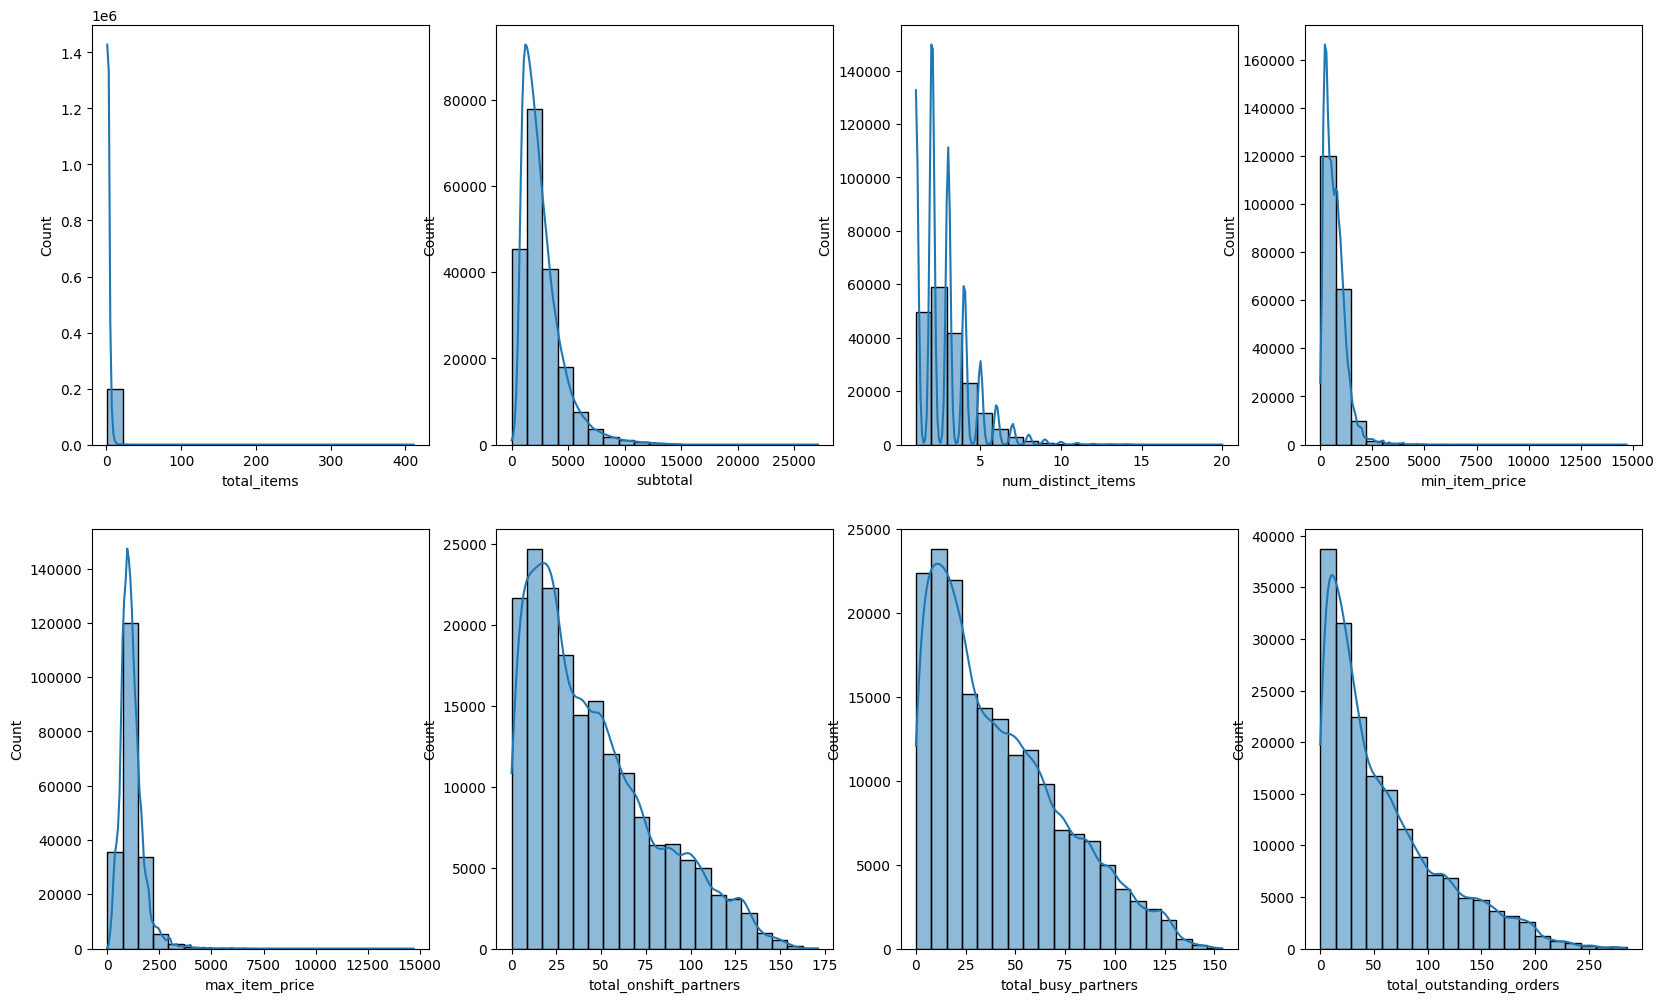

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Plot histograms for each variable in the specified subplots
sns.histplot(ax=ax1, x='total_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax2, x='subtotal', data=df, kde=True, bins=20)
sns.histplot(ax=ax3, x='num_distinct_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax4, x='min_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax5, x='max_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax6, x='total_onshift_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax7, x='total_busy_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax8, x='total_outstanding_orders', data=df, kde=True, bins=20)

# Display the plot
plt.show()

In [25]:
df.isna().sum()

store_primary_category       4758
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16261
total_busy_partners         16261
total_outstanding_orders    16261
Hour_of_day                     0
day_of_week                     0
del_time                        0
dtype: int64

In [26]:
df['store_primary_category'].unique()

array(['american', 'mexican', nan, 'indian', 'italian', 'sandwich',
       'thai', 'cafe', 'salad', 'pizza', 'chinese', 'singaporean',
       'burger', 'breakfast', 'mediterranean', 'japanese', 'greek',
       'catering', 'filipino', 'convenience-store', 'other', 'korean',
       'vegan', 'asian', 'barbecue', 'fast', 'dessert', 'smoothie',
       'seafood', 'vietnamese', 'cajun', 'steak', 'middle-eastern',
       'soup', 'vegetarian', 'persian', 'nepalese', 'sushi',
       'latin-american', 'hawaiian', 'chocolate', 'burmese', 'british',
       'pasta', 'alcohol', 'dim-sum', 'peruvian', 'turkish', 'malaysian',
       'ethiopian', 'afghan', 'bubble-tea', 'german', 'french',
       'caribbean', 'gluten-free', 'comfort-food', 'gastropub',
       'pakistani', 'moroccan', 'spanish', 'southern', 'tapas', 'russian',
       'brazilian', 'european', 'cheese', 'african', 'argentine',
       'kosher', 'irish', 'lebanese', 'belgian', 'indonesian',
       'alcohol-plus-food'], dtype=object)

### Fixing Mixing Values 2

In [27]:
df.isna().sum()

store_primary_category       4758
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16261
total_busy_partners         16261
total_outstanding_orders    16261
Hour_of_day                     0
day_of_week                     0
del_time                        0
dtype: int64

In [28]:
df.store_primary_category.fillna(df.store_primary_category.mode()[0], inplace=True)

df.order_protocol.fillna(df.order_protocol.mean(), inplace=True)
df.total_onshift_partners.fillna(df.total_onshift_partners.mean(), inplace=True)
df.total_busy_partners.fillna(df.total_busy_partners.mean(), inplace=True)
df.total_outstanding_orders.fillna(df.total_outstanding_orders.mean(), inplace=True)

### Encoding categorical columns

In [29]:
df['store_primary_category_probab'] = df['store_primary_category'].map(df['store_primary_category'].value_counts(1).to_dict())

df['order_protocol_probab'] = df['order_protocol'].map(df['order_protocol'].value_counts(1).to_dict())

In [30]:
df = pd.get_dummies(df, columns=['store_primary_category'])
df = pd.get_dummies(df, columns=['order_protocol'])

## Data Visualization & cleaning

### Visualization - Countplots/ Scatterplots

### Checking Outliers

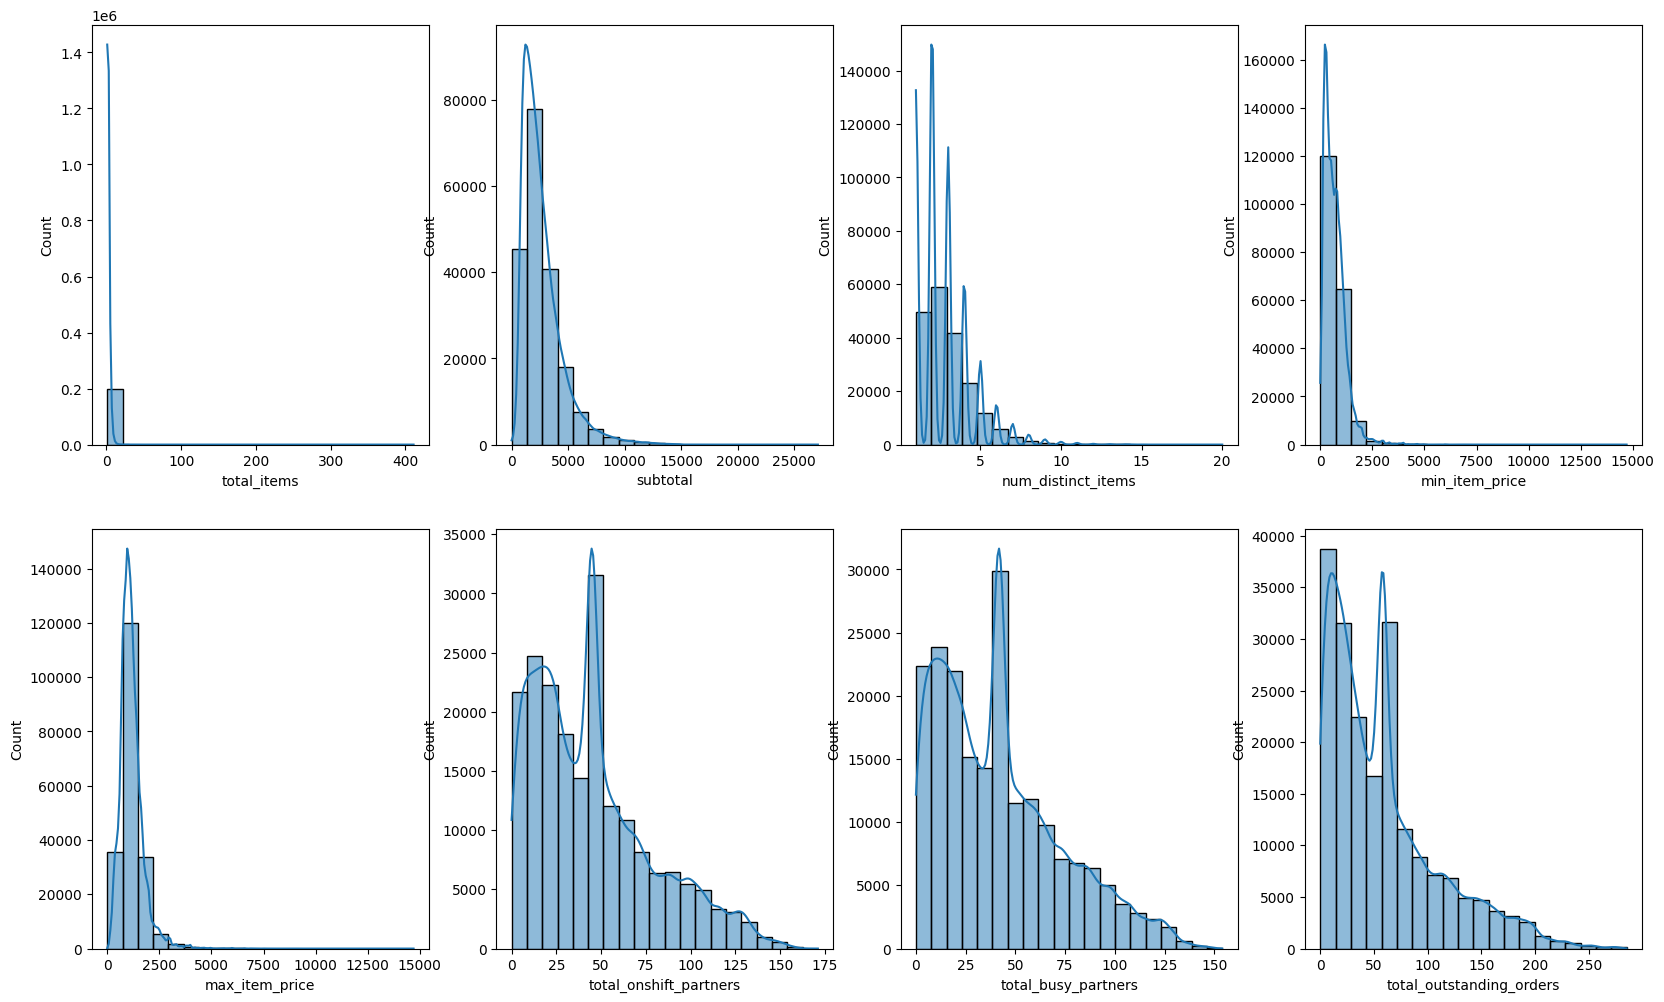

In [31]:
# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Plot histograms for each variable in the specified subplots
sns.histplot(ax=ax1, x='total_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax2, x='subtotal', data=df, kde=True, bins=20)
sns.histplot(ax=ax3, x='num_distinct_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax4, x='min_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax5, x='max_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax6, x='total_onshift_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax7, x='total_busy_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax8, x='total_outstanding_orders', data=df, kde=True, bins=20)

# Display the plot
plt.show()

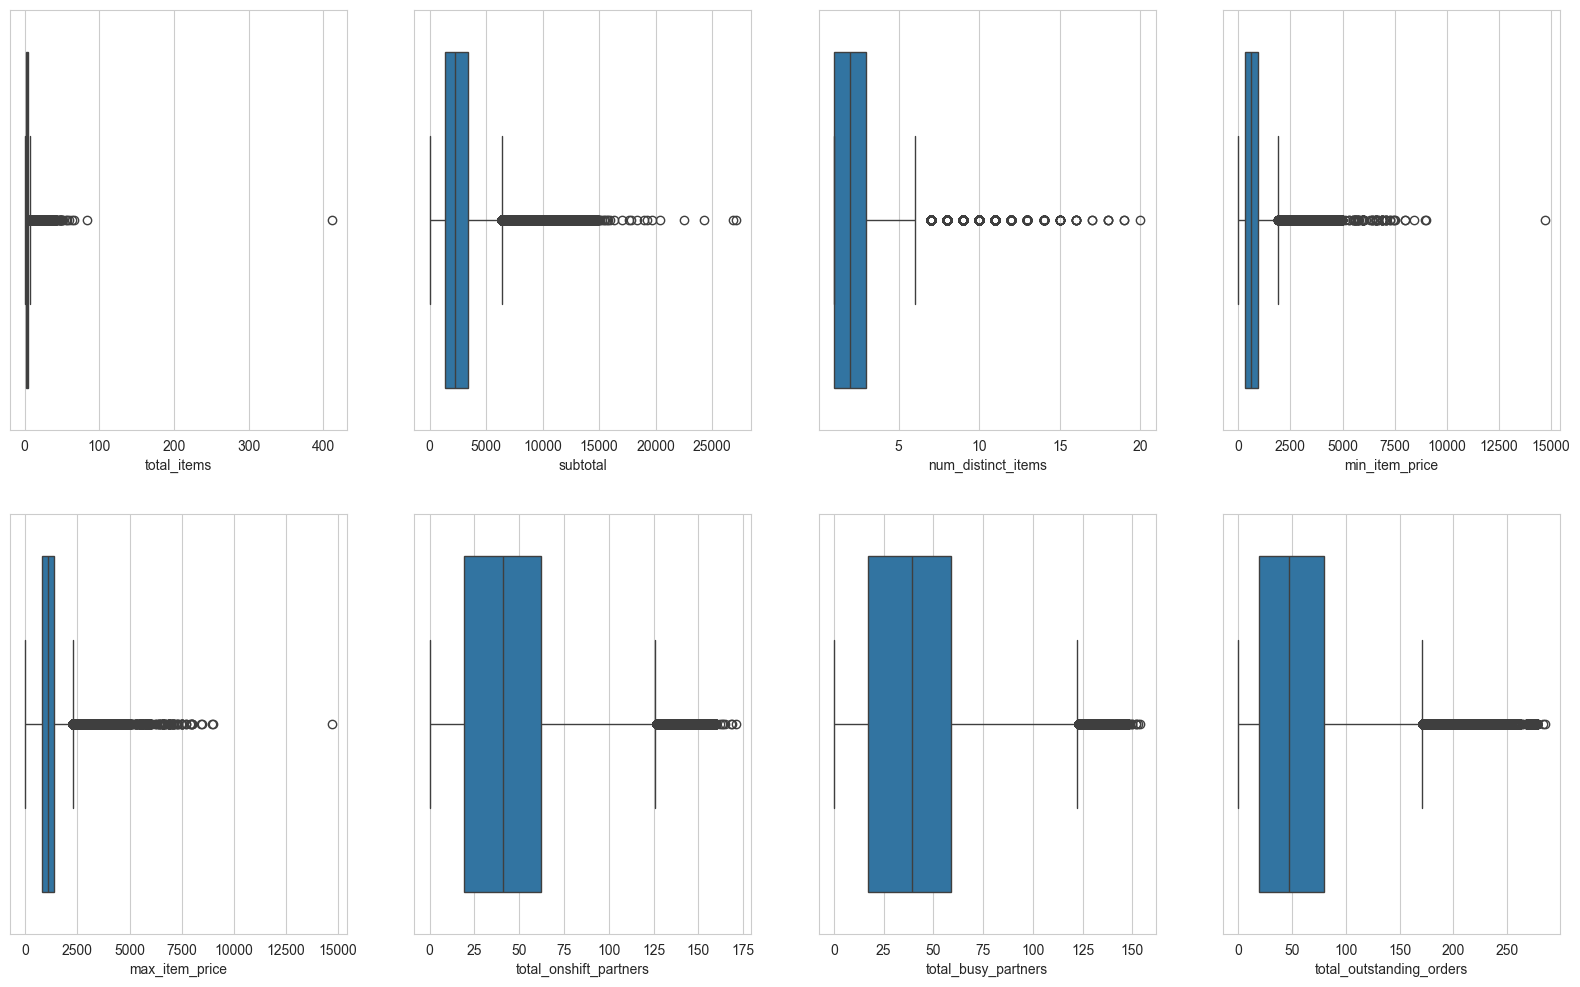

In [32]:
# Set the Seaborn style to 'whitegrid'
sns.set_style('whitegrid')

# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Create box plots for each variable in the specified subplots
sns.boxplot(ax=ax1, x='total_items', data=df)
sns.boxplot(ax=ax2, x='subtotal', data=df)
sns.boxplot(ax=ax3, x='num_distinct_items', data=df)
sns.boxplot(ax=ax4, x='min_item_price', data=df)
sns.boxplot(ax=ax5, x='max_item_price', data=df)
sns.boxplot(ax=ax6, x='total_onshift_partners', data=df)
sns.boxplot(ax=ax7, x='total_busy_partners', data=df)
sns.boxplot(ax=ax8, x='total_outstanding_orders', data=df)

# Display the plot
plt.show()

### Removing Outliers by IQR method

In [33]:
# Calculate the interquartile range (IQR) for each variable
Q1 = df[['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']].quantile(0.25)
Q3 = df[['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']].quantile(0.75)
IQR = Q3 - Q1

# Display the calculated IQR
print(IQR)

total_items                    2.0
subtotal                    1995.0
num_distinct_items             2.0
min_item_price               650.0
max_item_price               595.0
total_onshift_partners        43.0
total_busy_partners           42.0
total_outstanding_orders      61.0
dtype: float64


In [34]:
Lower = Q1-3.0*IQR
Upper = Q3+3.0*IQR

In [35]:
# Create boolean conditions for each variable using IQR boundaries
c0 = (df['total_items'] >= Lower['total_items']) & (df['total_items'] <= Upper['total_items'])
c1 = (df['subtotal'] >= Lower['subtotal']) & (df['subtotal'] <= Upper['subtotal'])
c2 = (df['num_distinct_items'] >= Lower['num_distinct_items']) & (df['num_distinct_items'] <= Upper['num_distinct_items'])
c3 = (df['min_item_price'] >= Lower['min_item_price']) & (df['min_item_price'] <= Upper['min_item_price'])
c4 = (df['max_item_price'] >= Lower['max_item_price']) & (df['max_item_price'] <= Upper['max_item_price'])
c5 = (df['total_onshift_partners'] >= Lower['total_onshift_partners']) & (df['total_onshift_partners'] <= Upper['total_onshift_partners'])
c6 = (df['total_busy_partners'] >= Lower['total_busy_partners']) & (df['total_busy_partners'] <= Upper['total_busy_partners'])
c7 = (df['total_outstanding_orders'] >= Lower['total_outstanding_orders']) & (df['total_outstanding_orders'] <= Upper['total_outstanding_orders'])

# Filter the DataFrame based on the combined boolean conditions
df = df[c0 & c1 & c2 & c3 & c4 & c5 & c6 & c7]

# Display the updated shape of the DataFrame
print("Shape after outlier removal:", df.shape)

Shape after outlier removal: (190530, 95)


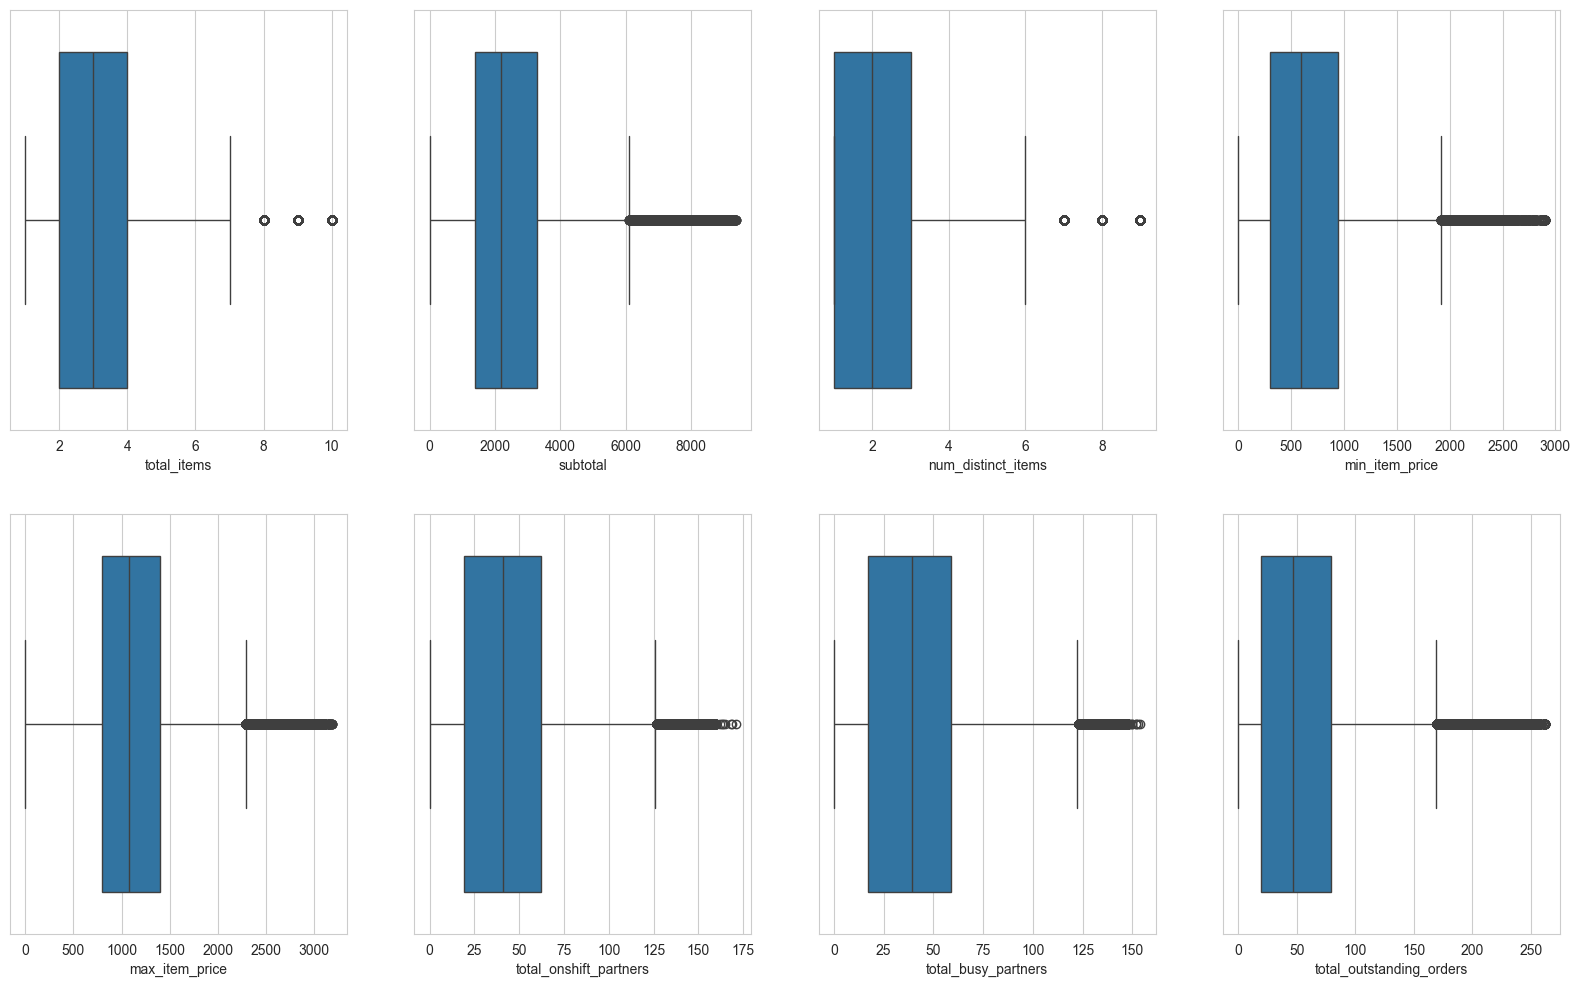

In [36]:
# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Create box plots for each variable in the specified subplots
sns.boxplot(ax=ax1, x='total_items', data=df)
sns.boxplot(ax=ax2, x='subtotal', data=df)
sns.boxplot(ax=ax3, x='num_distinct_items', data=df)
sns.boxplot(ax=ax4, x='min_item_price', data=df)
sns.boxplot(ax=ax5, x='max_item_price', data=df)
sns.boxplot(ax=ax6, x='total_onshift_partners', data=df)
sns.boxplot(ax=ax7, x='total_busy_partners', data=df)
sns.boxplot(ax=ax8, x='total_outstanding_orders', data=df)

# Display the plot
plt.show()

In [37]:
# Select the columns containing numerical variables
numerical_df = df[numerical_cols]

numerical_df.skew()

total_items                   1.240872
subtotal                      1.331472
num_distinct_items            1.100032
min_item_price                1.118135
max_item_price                0.891107
total_onshift_partners        0.894290
total_busy_partners           0.809846
total_outstanding_orders      1.223604
del_time                    432.070420
dtype: float64

In [38]:
numerical_df.kurt()

total_items                      1.537199
subtotal                         1.949945
num_distinct_items               1.270867
min_item_price                   1.630148
max_item_price                   1.391462
total_onshift_partners           0.218519
total_busy_partners              0.040790
total_outstanding_orders         1.082505
del_time                    187923.134934
dtype: float64

In [43]:
df.columns

Index(['total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'Hour_of_day', 'day_of_week', 'del_time',
       'store_primary_category_probab', 'order_protocol_probab',
       'store_primary_category_afghan', 'store_primary_category_african',
       'store_primary_category_alcohol',
       'store_primary_category_alcohol-plus-food',
       'store_primary_category_american', 'store_primary_category_argentine',
       'store_primary_category_asian', 'store_primary_category_barbecue',
       'store_primary_category_belgian', 'store_primary_category_brazilian',
       'store_primary_category_breakfast', 'store_primary_category_british',
       'store_primary_category_bubble-tea', 'store_primary_category_burger',
       'store_primary_category_burmese', 'store_primary_category_cafe',
       'store_primary_category_cajun', 'store_primary_category_caribbean',
       'store_

In [44]:
numerical_cols.extend(['store_primary_category_probab', 'order_protocol_probab'])

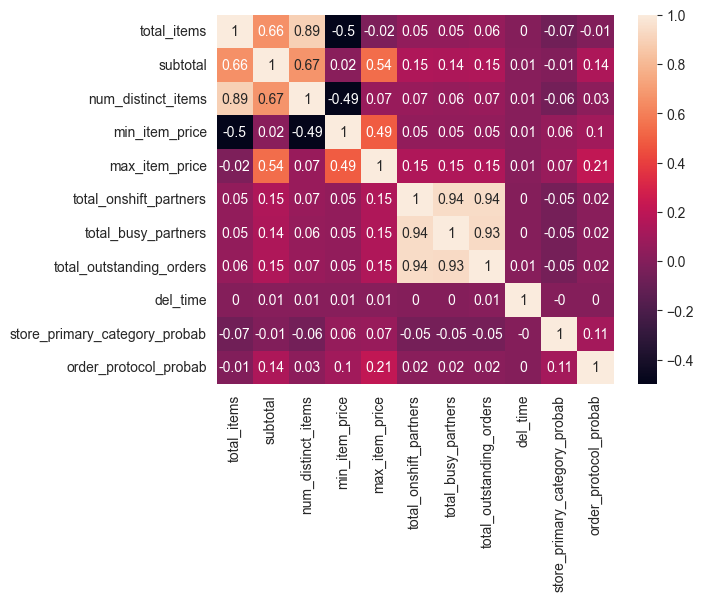

In [45]:
# Calculate and round the correlation matrix between the interval variables
correlation_matrix = df[numerical_cols].corr().round(2)

# Display the correlation matrix
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [40]:
df.columns

Index(['total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'Hour_of_day', 'day_of_week', 'del_time',
       'store_primary_category_probab', 'order_protocol_probab',
       'store_primary_category_afghan', 'store_primary_category_african',
       'store_primary_category_alcohol',
       'store_primary_category_alcohol-plus-food',
       'store_primary_category_american', 'store_primary_category_argentine',
       'store_primary_category_asian', 'store_primary_category_barbecue',
       'store_primary_category_belgian', 'store_primary_category_brazilian',
       'store_primary_category_breakfast', 'store_primary_category_british',
       'store_primary_category_bubble-tea', 'store_primary_category_burger',
       'store_primary_category_burmese', 'store_primary_category_cafe',
       'store_primary_category_cajun', 'store_primary_category_caribbean',
       'store_

### Split the data to train, val and test datasets

In [49]:
X = df.drop(columns=['del_time'])
y = df['del_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [42]:
df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,...,store_primary_category_vegetarian,store_primary_category_vietnamese,order_protocol_1.0,order_protocol_2.0,order_protocol_2.8824134629097653,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,4,3441,4,557,1239,33.0,14.0,21.0,22,4,...,False,False,True,False,False,False,False,False,False,False
1,1,1900,1,1400,1400,1.0,2.0,2.0,21,1,...,False,False,False,True,False,False,False,False,False,False
2,1,1900,1,1900,1900,1.0,0.0,0.0,20,3,...,False,False,True,False,False,False,False,False,False,False
3,6,6900,5,600,1800,1.0,1.0,2.0,21,1,...,False,False,True,False,False,False,False,False,False,False
4,3,3900,3,1100,1600,6.0,6.0,9.0,2,6,...,False,False,True,False,False,False,False,False,False,False


## Modeling

### Base Model

In [50]:
rf = RandomForestRegressor(max_depth=6, n_estimators=100, criterion='squared_error', random_state=42)

rf.fit(X_train, y_train)

pd.Series(rf.feature_importances_, index=X.columns)

total_items           0.009612
subtotal              0.067547
num_distinct_items    0.000089
min_item_price        0.018466
max_item_price        0.041314
                        ...   
order_protocol_3.0    0.026902
order_protocol_4.0    0.000923
order_protocol_5.0    0.096234
order_protocol_6.0    0.001846
order_protocol_7.0    0.000000
Length: 94, dtype: float64

In [55]:
feat_imp_series = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

feat_imp_series

Hour_of_day                              0.336896
day_of_week                              0.155110
order_protocol_5.0                       0.096234
subtotal                                 0.067547
total_onshift_partners                   0.062367
                                           ...   
store_primary_category_irish             0.000000
store_primary_category_kosher            0.000000
store_primary_category_latin-american    0.000000
store_primary_category_lebanese          0.000000
order_protocol_7.0                       0.000000
Length: 94, dtype: float64

In [56]:
feat_imp_series.iloc[:10]

Hour_of_day                 0.336896
day_of_week                 0.155110
order_protocol_5.0          0.096234
subtotal                    0.067547
total_onshift_partners      0.062367
total_busy_partners         0.058569
max_item_price              0.041314
total_outstanding_orders    0.038129
order_protocol_probab       0.037029
order_protocol_1.0          0.033593
dtype: float64

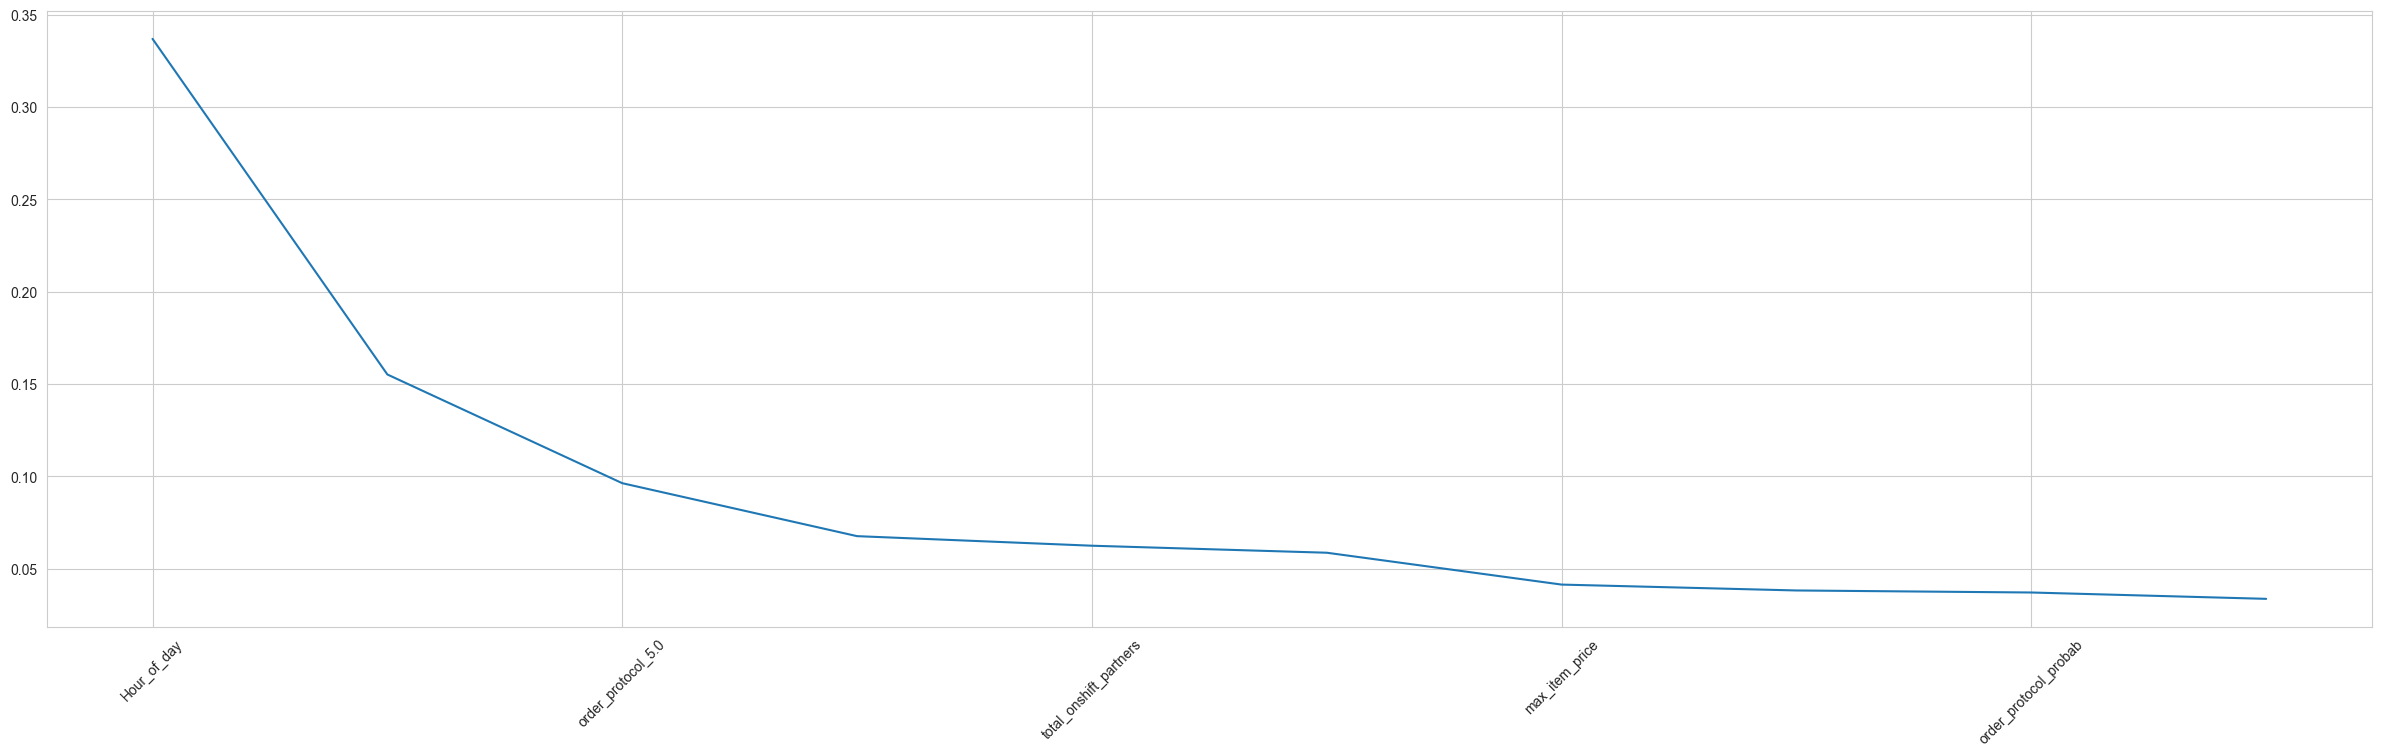

In [61]:

feat_imp_series.iloc[:10].plot(kind='line',rot=45, figsize=(30,8))
plt.show()

- the delivery time is generally affected by the quantity of items to be delivered, its weight, its value (more value might need special packaging or may not), the rush during the time of delivery

In [ ]:
## Baseline Model Generator for NN

def create_baseline():

  model = Sequential([
                    Dense(32, activation="relu",kernel_initializer='glorot_uniform'),
                    Dense(64, activation="relu",kernel_initializer='glorot_uniform'),
                    Dense(128, activation="relu",kernel_initializer='glorot_uniform'),
                    Dense(64, activation="relu",kernel_initializer='glorot_uniform'),
                    Dense(32, activation="relu",kernel_initializer='glorot_uniform'),
                    Dense(3,activation='softmax')])
  return model